# AAPL price forecasting
- This is an ipynb file created in colab environment.
- Runtime : GPU
- stacked LSTM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Github/Time-series_price_analysis')

In [ ]:
!ls /content/drive/MyDrive/Github/Time-series_price_analysis/*.py

/content/drive/MyDrive/Github/Time-series_price_analysis/make_dataset.py


## 0. Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random as rn
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import tensorflow as tf
import os

from make_dataset import time_transform, make_input

In [ ]:
# reproducibility
seed_num = 42
rn.seed(seed_num)
tf.random.set_seed(seed_num)
os.environ['PYTHONHASHSEED']=str(seed_num)

from keras import backend as K
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

## 1. Load and visualize dataset

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Github/Time-series_price_analysis/dataset/AAPL.csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 25, 2022",174.73,173.90,175.27,172.77,73.63M,0.38%
1,"Mar 24, 2022",174.07,171.06,174.14,170.21,89.68M,2.27%
2,"Mar 23, 2022",170.21,167.99,172.64,167.65,97.30M,0.82%
3,"Mar 22, 2022",168.82,165.51,169.42,164.91,80.94M,2.08%
4,"Mar 21, 2022",165.38,163.51,166.35,163.01,95.81M,0.85%


In [ ]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
2534,"Mar 02, 2012",19.47,19.44,19.53,19.38,431.71M,0.10%
2535,"Mar 01, 2012",19.45,19.58,19.58,19.24,683.25M,0.41%
2536,"Feb 29, 2012",19.37,19.34,19.56,19.13,952.00M,1.31%
2537,"Feb 28, 2012",19.12,18.86,19.12,18.78,600.39M,1.81%
2538,"Feb 27, 2012",18.78,18.62,18.87,18.44,547.58M,0.64%


In [ ]:
df['Date'] = df['Date'].apply(lambda x: time_transform(x))
dataset = df.sort_values('Date').reset_index(drop=True)

In [ ]:
print("Shape of dataset :", dataset.shape)
dataset.head()

Shape of dataset : (2539, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,2012-02-27,18.78,18.62,18.87,18.44,547.58M,0.64%
1,2012-02-28,19.12,18.86,19.12,18.78,600.39M,1.81%
2,2012-02-29,19.37,19.34,19.56,19.13,952.00M,1.31%
3,2012-03-01,19.45,19.58,19.58,19.24,683.25M,0.41%
4,2012-03-02,19.47,19.44,19.53,19.38,431.71M,0.10%


In [ ]:
date = dataset['Date'].values
close = dataset['Price'].values

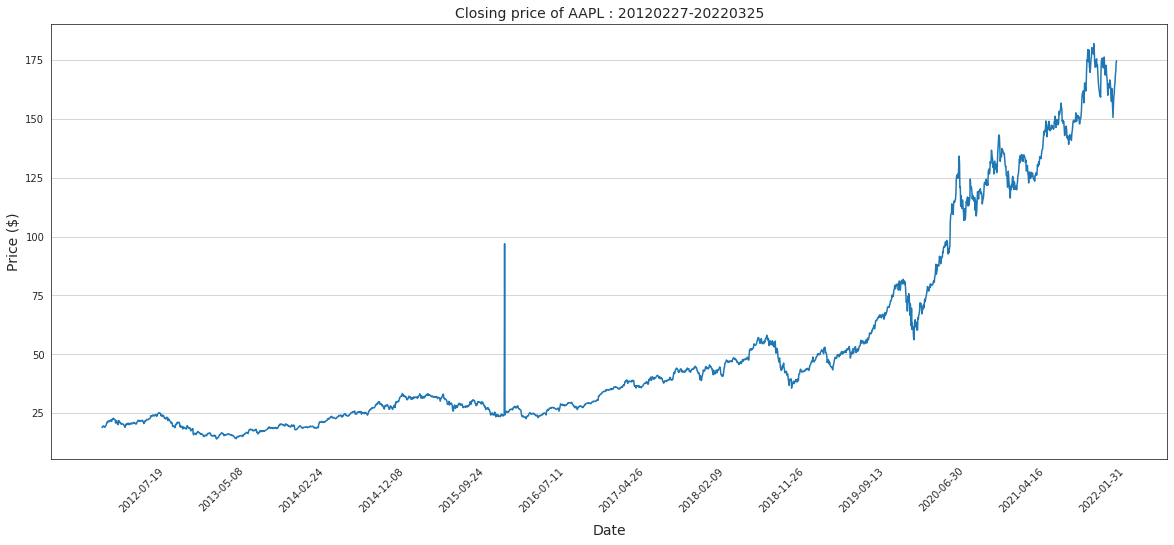

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(date, close)
plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(100,len(date),200), rotation=45)
plt.grid(True, axis='y')
plt.show()

## 2. Preprocessing

- Min-max scaling

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(np.array(close).reshape(-1,1))

In [ ]:
print(scaled_close)

[[0.02873974]
 [0.03076282]
 [0.03225039]
 ...
 [0.92978698]
 [0.95275497]
 [0.95668214]]


- Split train and test dataset

In [ ]:
train_size = int(len(close)*0.795)
val_size = len(close)-train_size
train_data, val_data = scaled_close[0:train_size,:], scaled_close[train_size:len(close),:1]

In [ ]:
train_size,test_size

(2018, 521)

In [ ]:
time_step = 1
X_train, y_train = make_input(train_data, time_step)
X_val, y_val = make_input(val_data, time_step)

In [ ]:
print("X train shape :", X_train.shape)
print("y train shape :", y_train.shape)
print("X val shape :", X_val.shape)
print("y val shape :", y_val.shape)

X train shape : (2016, 1)
y train shape : (2016,)
X val shape : (519, 1)
y val shape : (519,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1] , 1)

print("X train shape :", X_train.shape)
print("X val shape :", X_val.shape)

X train shape : (2016, 1, 1)
X val shape : (519, 1, 1)


## 3. Modeling - LSTM

In [ ]:
model = Sequential()

model.add(LSTM(50, return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1, kernel_initializer=tf.keras.initializers.glorot_uniform(seed=seed_num)))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 1, 50)             10400     
                                                                 
 lstm_16 (LSTM)              (None, 1, 50)             20200     
                                                                 
 lstm_17 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
adam = Adam(learning_rate=0.001)
chk = ModelCheckpoint('/content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl', monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)
model.compile(loss='mse', optimizer = adam)

In [ ]:
%%time
hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[chk], epochs=30, batch_size = 64, verbose = 1, shuffle = False)

Epoch 1/100
28/32 [=========================>....] - ETA: 0s - loss: 0.0035
Epoch 1: val_loss improved from inf to 0.28212, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 24s 606ms/step - loss: 0.0056 - val_loss: 0.2821
Epoch 2/100
28/32 [=========================>....] - ETA: 0s - loss: 0.0087
Epoch 2: val_loss did not improve from 0.28212
32/32 [==============================] - 0s 10ms/step - loss: 0.0109 - val_loss: 0.3180
Epoch 3/100
31/32 [============================>.] - ETA: 0s - loss: 0.0067
Epoch 3: val_loss did not improve from 0.28212
32/32 [==============================] - 0s 12ms/step - loss: 0.0077 - val_loss: 0.3033
Epoch 4/100
31/32 [============================>.] - ETA: 0s - loss: 0.0068
Epoch 4: val_loss did not improve from 0.28212
32/32 [==============================] - 0s 14ms/step - loss: 0.0076 - val_loss: 0.2864
Epoch 5/100
29/32 [==========================>...] - ETA: 0s - loss: 0.0054
Epoch 5: val_loss improved from 0.28212 to 0.26256, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 36s 1s/step - loss: 0.0074 - val_loss: 0.2626
Epoch 6/100
30/32 [===========================>..] - ETA: 0s - loss: 0.0053
Epoch 6: val_loss improved from 0.26256 to 0.22437, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 19s 622ms/step - loss: 0.0068 - val_loss: 0.2244
Epoch 7/100
27/32 [========================>.....] - ETA: 0s - loss: 0.0047
Epoch 7: val_loss improved from 0.22437 to 0.16476, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 20s 633ms/step - loss: 0.0060 - val_loss: 0.1648
Epoch 8/100
31/32 [============================>.] - ETA: 0s - loss: 0.0044
Epoch 8: val_loss improved from 0.16476 to 0.08091, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 19s 609ms/step - loss: 0.0047 - val_loss: 0.0809
Epoch 9/100
27/32 [========================>.....] - ETA: 0s - loss: 0.0029
Epoch 9: val_loss improved from 0.08091 to 0.00701, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 27s 856ms/step - loss: 0.0029 - val_loss: 0.0070
Epoch 10/100
27/32 [========================>.....] - ETA: 0s - loss: 0.0014
Epoch 10: val_loss did not improve from 0.00701
32/32 [==============================] - 0s 11ms/step - loss: 0.0013 - val_loss: 0.0201
Epoch 11/100
27/32 [========================>.....] - ETA: 0s - loss: 3.5067e-04
Epoch 11: val_loss did not improve from 0.00701
32/32 [==============================] - 0s 11ms/step - loss: 3.2834e-04 - val_loss: 0.0226
Epoch 12/100
31/32 [============================>.] - ETA: 0s - loss: 2.4969e-04
Epoch 12: val_loss did not improve from 0.00701
32/32 [==============================] - 0s 11ms/step - loss: 2.5151e-04 - val_loss: 0.0083
Epoch 13/100
31/32 [============================>.] - ETA: 0s - loss: 3.5598e-04
Epoch 13: val_loss did not improve from 0.00701
32/32 [==============================] - 0s 11ms/step - loss: 3.5717e-04 - val_loss: 0.0076
Epoch 14/100
32/32 [==============

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 20s 634ms/step - loss: 3.6450e-04 - val_loss: 0.0065
Epoch 15/100
31/32 [============================>.] - ETA: 0s - loss: 3.3476e-04
Epoch 15: val_loss improved from 0.00645 to 0.00451, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 18s 577ms/step - loss: 3.3548e-04 - val_loss: 0.0045
Epoch 16/100
31/32 [============================>.] - ETA: 0s - loss: 3.2741e-04
Epoch 16: val_loss improved from 0.00451 to 0.00308, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 16s 526ms/step - loss: 3.2747e-04 - val_loss: 0.0031
Epoch 17/100
27/32 [========================>.....] - ETA: 0s - loss: 3.6536e-04
Epoch 17: val_loss improved from 0.00308 to 0.00203, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 20s 650ms/step - loss: 3.2187e-04 - val_loss: 0.0020
Epoch 18/100
28/32 [=========================>....] - ETA: 0s - loss: 3.4459e-04
Epoch 18: val_loss improved from 0.00203 to 0.00125, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 23s 751ms/step - loss: 3.1392e-04 - val_loss: 0.0012
Epoch 19/100
27/32 [========================>.....] - ETA: 0s - loss: 3.4744e-04
Epoch 19: val_loss improved from 0.00125 to 0.00072, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 20s 650ms/step - loss: 3.0532e-04 - val_loss: 7.1534e-04
Epoch 20/100
32/32 [==============================] - ETA: 0s - loss: 2.9627e-04
Epoch 20: val_loss improved from 0.00072 to 0.00040, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 19s 599ms/step - loss: 2.9627e-04 - val_loss: 3.9611e-04
Epoch 21/100
28/32 [=========================>....] - ETA: 0s - loss: 3.1593e-04
Epoch 21: val_loss improved from 0.00040 to 0.00026, saving model to /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl/assets


32/32 [==============================] - 15s 486ms/step - loss: 2.8691e-04 - val_loss: 2.5576e-04
Epoch 22/100
29/32 [==========================>...] - ETA: 0s - loss: 2.9627e-04
Epoch 22: val_loss did not improve from 0.00026
32/32 [==============================] - 0s 9ms/step - loss: 2.7739e-04 - val_loss: 2.6120e-04
Epoch 23/100
26/32 [=======================>......] - ETA: 0s - loss: 3.1456e-04
Epoch 23: val_loss did not improve from 0.00026
32/32 [==============================] - 0s 10ms/step - loss: 2.6785e-04 - val_loss: 3.8061e-04
Epoch 24/100
29/32 [==========================>...] - ETA: 0s - loss: 2.7621e-04
Epoch 24: val_loss did not improve from 0.00026
32/32 [==============================] - 0s 10ms/step - loss: 2.5845e-04 - val_loss: 5.8390e-04
Epoch 25/100
28/32 [=========================>....] - ETA: 0s - loss: 2.7478e-04
Epoch 25: val_loss did not improve from 0.00026
32/32 [==============================] - 0s 10ms/step - loss: 2.4935e-04 - val_loss: 8.4333e-04
Epo

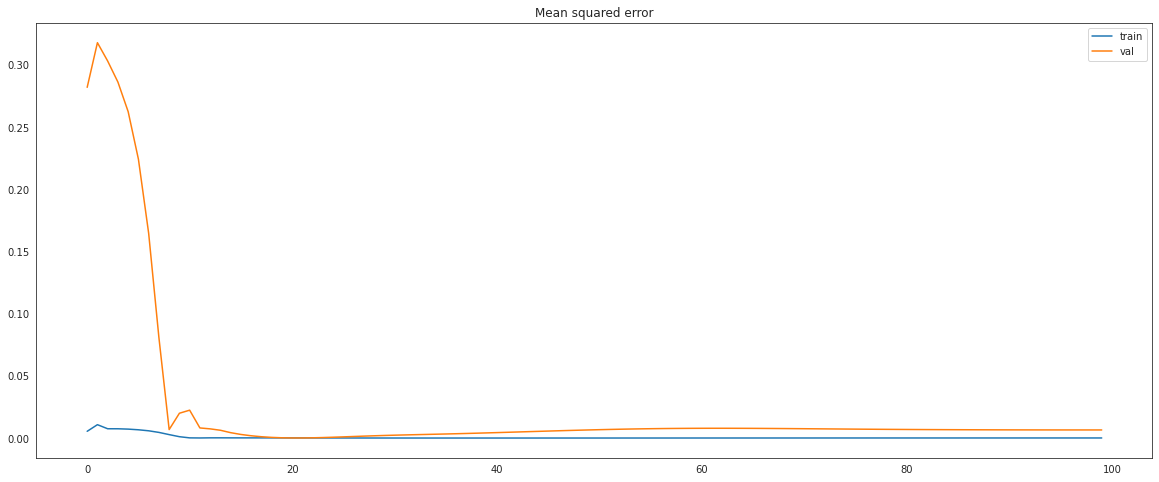

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend()
plt.title("Mean squared error")
plt.show()

## 4. Evaluation

In [ ]:
loaded_model = load_model("/content/drive/MyDrive/Github/Time-series_price_analysis/model_weights/aapl/lstm.pkl")

In [ ]:
train_predicton = loaded_model.predict(X_train)
val_prediction = loaded_model.predict(X_val)

print("Train pred shape :", train_predicton.shape)
print("Val pred shape :", val_prediction.shape)

Train pred shape : (2016, 1)
Val pred shape : (519, 1)


In [ ]:
train_pred = scaler.inverse_transform(train_predicton)
val_pred = scaler.inverse_transform(val_prediction)
print(val_pred[:5])

[[76.45928 ]
 [74.00001 ]
 [73.02795 ]
 [67.316795]
 [72.09689 ]]


In [ ]:
close = np.array(close)
cc = close.reshape((len(close), 1))
tt1, tt2 = cc[0:train_size,:], cc[train_size:len(close),:]
xtrain, ytrain = make_input(tt1, 1)
Xval, yval = make_input(tt2, 1)

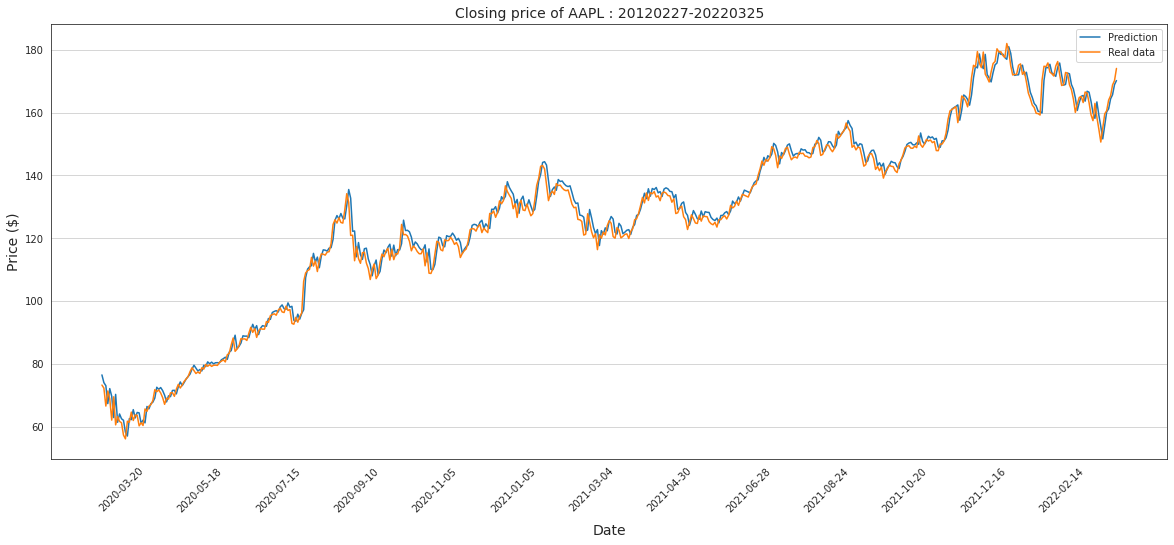

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(date[-len(val_pred):], val_pred, label='Prediction')
plt.plot(date[-len(val_pred):], yval, label='Real data')
plt.legend()
plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(10,len(val_pred),40), rotation=45)
plt.grid(True, axis='y')
plt.show()

 - zoom in!

In [ ]:
len(val_pred)

519

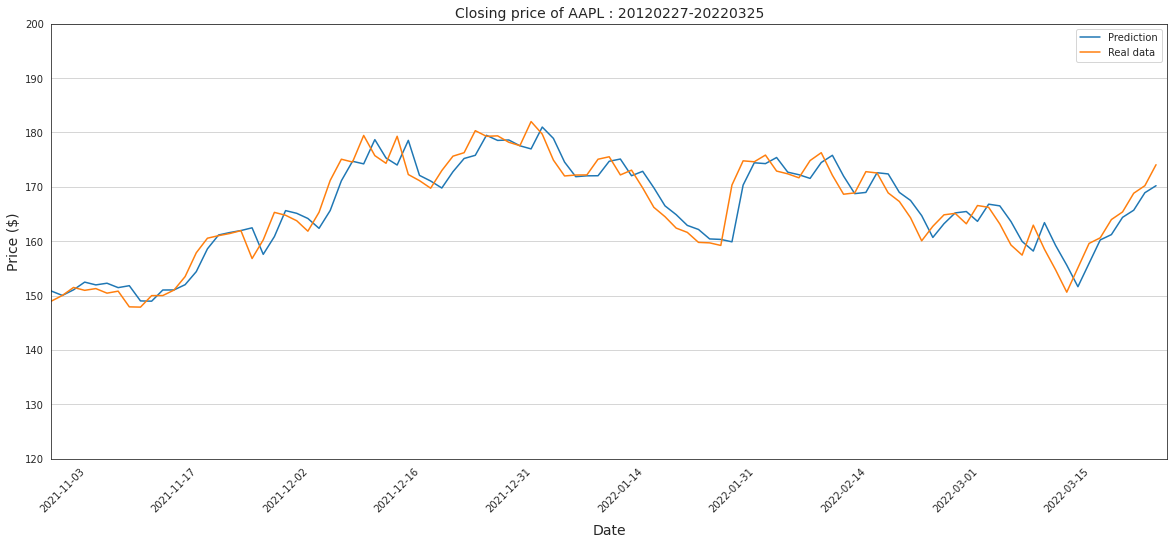

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(date[-len(val_pred):], val_pred, label='Prediction')
plt.plot(date[-len(val_pred):], yval, label='Real data')
plt.legend()
plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(10,len(val_pred),10), rotation=45)
plt.grid(True, axis='y')
plt.axis([419, 519, 120, 200])
plt.show()

In [ ]:
val_rmse = math.sqrt(mean_squared_error(yval, val_pred))
print('Val RMSE: %.3f' % val_rmse)

Val RMSE: 2.688


In [ ]:
print("Shape of closing data :", np.shape(close))

cycle = np.arange(len(close))
cycle1 = cycle[0:train_size-2]
cycle2 = cycle[train_size+2:len(close)]

print(np.shape(cycle1), np.shape(cycle2))

Shape of closing data : (2539,)
(2016,) (519,)


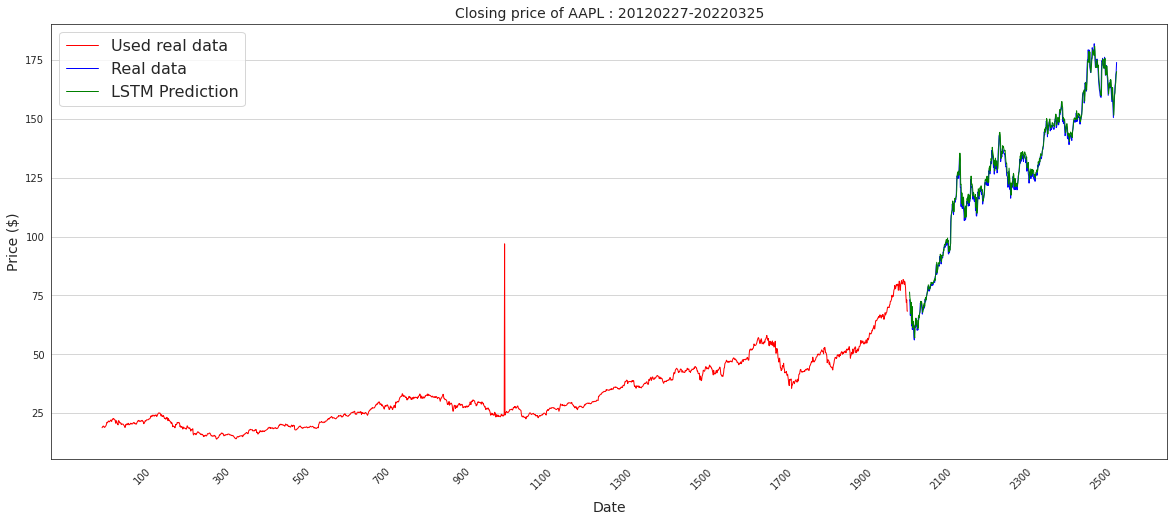

In [ ]:
sns.set_style("white")
plt.figure(figsize=(20,8))

plt.plot(cycle1, xtrain[:,0],label='Used real data', linewidth = 1, color='r')
plt.plot(cycle2, yval,label='Real data', linewidth = 1, color='b')
plt.plot(cycle2, val_pred[:,0],label='LSTM Prediction', linewidth = 1, color='g')
plt.legend(prop={'size': 16})

plt.title("Closing price of AAPL : 20120227-20220325", fontsize = 14)
plt.xlabel('Date', fontsize = 14, labelpad=10)
plt.ylabel('Price ($)', fontsize = 14)
plt.xticks(np.arange(100,len(date),200), rotation=45)
plt.grid(True, axis='y')
plt.show()